# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from brian2 import *
from brian2tools import brian_plot, plot_state

from TacNet import TacNet


set_device('cpp_standalone')
# Suppress code generation messages on the console
# BrianLogger.suppress_hierarchy('brian2.codegen')
# Suppress preference messages even in the log file
BrianLogger.suppress_hierarchy('brian2.core.preferences', filter_log_file=True)

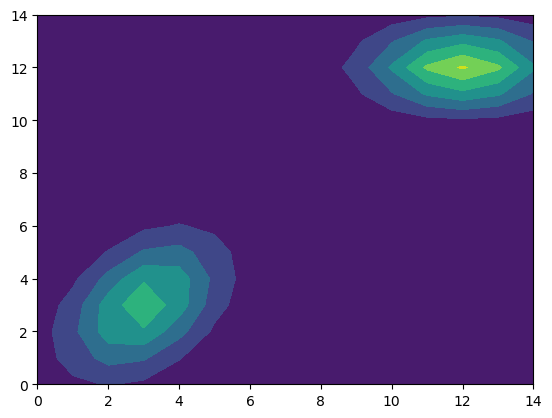

In [13]:
# Copyright 2023 wngfra.
# SPDX-License-Identifier: Apache-2.0
# TODO: use normal probability to the synaptic connection for the Gaussian receptive field
from scipy.stats import multivariate_normal

x, y = np.mgrid[0:15:1, 0:15:1]
pos = np.dstack((x, y))

rv1 = multivariate_normal([3, 3], [[2.0, 2.0], [1.0, 3.0]])
rv2 = multivariate_normal([12, 12], [[3.0, 0.0], [0.0, 1.0]])

fig2 = plt.figure()

ax2 = fig2.add_subplot(111)

ax2.contourf(x, y, rv1.pdf(pos)+rv2.pdf(pos))
plt.show()

# Test TacNet - tactile encoding spiking network

In [2]:
dt = 1*ms

# Load dataset
dataset = np.load("../data/touch.pkl", allow_pickle=True)
sensordata = dataset['sharp_site']['sensordata']
orientations = dataset['sharp_site']['orientations']
data = np.asarray(sensordata)

# Convert values to spikes
length, height, width = data.shape
inputs = data.reshape(length, -1)
inputs[inputs > 0] = 1.
I = TimedArray(inputs*200*pA, dt=dt)
if 'initiated' in locals():
    device.reinit()
    device.activate()
else:
    initiated = True

duration = I.values.shape[0]*dt
num_neurons = [height*width, 16, 36]
model = TacNet(num_neurons)
mons = model.run(I, duration)

# Plot results
fig, axs = plt.subplots(7, 1, figsize=(20, 21))
for i in range(3):
    axs[i].set_title('Spike L'+str(i+1))
    brian_plot(mons['SpikeMonitor_L'+str(i+1)], axes=axs[i])

axs[3].set_title('L3 Membrane Potential')
plot_state(mons['StateMonitor_L3'].t, mons['StateMonitor_L3'].v.T, axes=axs[3])
axs[4].set_title('Syn23 X')
plot_state(mons['StateMonitor_Syn23'].t,
            mons['StateMonitor_Syn23'].X.T, axes=axs[4])
axs[5].set_title('Syn12 Connectivity')
brian_plot(model.net['Syn12'], axes=axs[5])
axs[6].set_title('Syn23 Final X')
axs[6].set_xlabel('target neuron index')
axs[6].set_ylabel('source neuron index')
axs[6].imshow(model.net['Syn23'].X_[:].reshape(
    (num_neurons[1], num_neurons[2])))
plt.tight_layout()
plt.show()


225 224


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (225,) and arg 1 with shape (224,).

<!--
 Copyright 2023 wngfra.
 SPDX-License-Identifier: Apache-2.0
-->



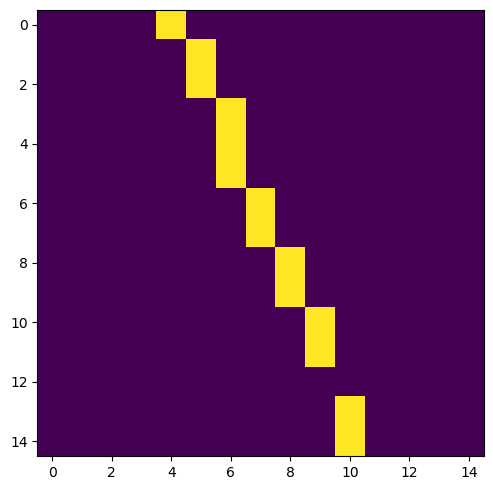

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(data[1010, :, :])
# axs[1].plot(orientations)
plt.tight_layout()
plt.show()

# Reference
1. F. Pascal, L. Bombrun, J. -Y. Tourneret and Y. Berthoumieu, "Parameter Estimation For Multivariate Generalized Gaussian Distributions," in IEEE Transactions on Signal Processing, vol. 61, no. 23, pp. 5960-5971, Dec.1, 2013, doi: 10.1109/TSP.2013.2282909.
2. A. Parvizi-Fard, M. Amiri, D. Kumar, M. M. Iskarous, and N. V. Thakor, “A functional spiking neuronal network for tactile sensing pathway to process edge orientation,” Sci Rep, vol. 11, no. 1, p. 1320, Dec. 2021, doi: 10.1038/s41598-020-80132-4.
3. J. A. Pruszynski and R. S. Johansson, “Edge-orientation processing in first-order tactile neurons,” Nat Neurosci, vol. 17, no. 10, pp. 1404–1409, Oct. 2014, doi: 10.1038/nn.3804.
4. J. M. Yau, S. S. Kim, P. H. Thakur, and S. J. Bensmaia, “Feeling form: the neural basis of haptic shape perception,” Journal of Neurophysiology, vol. 115, no. 2, pp. 631–642, Feb. 2016, doi: 10.1152/jn.00598.2015.
5. G. Sutanto, Z. Su, S. Schaal, and F. Meier, “Learning Sensor Feedback Models from Demonstrations via Phase-Modulated Neural Networks,” in 2018 IEEE International Conference on Robotics and Automation (ICRA), Brisbane, QLD, May 2018, pp. 1142–1149. doi: 10.1109/ICRA.2018.8460986.